# Example: a buy and hold strategy


In [1]:
from typing import override
from pprint import pprint
import matplotlib.pyplot as plt

from systrade import (
    BacktestBroker,
    BarData,
    Engine,
    ExecutionReport,
    FileFeed,
    Strategy,
)

## Creating a strategy


Perhaps one of the more sophisticated strategies out there, they buy and hold
strategy buys a security at a point in time and then does nothing else. Let's
use the framework we developed to implement that strategy.

Look to the methods marked with `@abstractmethod` in `Strategy`. Those are the
ones you need to implement in a concrete strategy implementation.


In [2]:
class BuyHoldStrategy(Strategy):
    """A buy and hold strategy that utilizes all cash available in the portfolio
    at the beginning to buy a stock and holds until the end.
    """

    def __init__(self, symbol: str) -> None:
        """Initialize a buy and hold strategy

        Parameters
        ----------
        symbol
            The symbol we wish to invest in
        """
        # Good practice to call this so base class gets properly initialized
        super().__init__()
        self.symbol = symbol

    @override
    def on_start(self) -> None:
        # To get data chugging through `on_data` we need to subscribe to the
        # symbols we're interested in
        self.subscribe(self.symbol)

    @override
    def on_data(self, data: BarData) -> None:
        # We can check whether we're invested in the security. If not, we'll buy
        # otherwise we don't want to do anything.
        if not self.portfolio.is_invested_in(self.symbol):
            # The data object has dictionary like semantics. We can get the
            # current closing price which we'll use to approximate the number of
            # shares we can afford. We won't get filled until the next bar's
            # open, however, so we may have residual cash + or - (negative
            # indicates we've borrowed a small amount). Note that most brokers
            # allow fractional shares so this quantity doesn't have to be a
            # whole number.
            current_price = data[self.symbol].close
            # We can access the current state of our portfolio with the
            # .portfolio accessor
            quantity = self.portfolio.cash() / current_price
            # We can submit orders to the broker using the post_market_order
            # function.
            # NOTE: if we wanted to sell, we'd use a negative quantity
            self.post_market_order(self.symbol, quantity)
            print(
                f"Submitted market order: symbol={self.symbol}"
                f"@ price={current_price} for quantity={quantity}"
            )

    @override
    def on_execution(self, report: ExecutionReport) -> None:
        # When we get a fill this event will be triggered
        print("Notified of execution:")
        pprint(report, indent=2)

## Setting up the engine


Now we can instantiate our players. The `FileFeed` can be used to replay market
data events from a file. The `BacktestBroker` simulates filling orders based on
the prevailing market environment. Then we also provide the strategy we
implemented along with a starting cash amount.


In [3]:
cash = 1000
feed = FileFeed("history.csv", start="2018-01-1", end="2018-02-01")
broker = BacktestBroker()
strategy = BuyHoldStrategy("NVDA")
engine = Engine(feed, broker, strategy, cash)

/Users/232724/Documents/financial_modeling/systrade/src/systrade/feed.py:53: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.path["Date"] = pd.to_datetime(self.path["Date"])


## Running the strategy and viewing results


Now let's run it.


In [4]:
engine.run()

2018-01-01 00:00:00 2018-02-01 00:00:00
Submitted market order: symbol=NVDA@ price=Series([], Name: Close, dtype: float64) for quantity=Series([], Name: Close, dtype: float64)
2005-01-04 00:00:00-05:00 2018-02-01 00:00:00
Notified of execution:
ExecutionReport(order=Order(id='1',
                            symbol='NVDA',
                            quantity=Series([], Name: Close, dtype: float64),
                            type=<OrderType.MARKET: 1>,
                            submit_time=datetime.datetime(2018, 1, 1, 0, 0),
                            price=None),
                last_price=5199    0.181467
Name: Open, dtype: float64,
                last_quantity=Series([], Name: Close, dtype: float64),
                cum_quantity=Series([], Name: Close, dtype: float64),
                rem_quantity=0.0,
                fill_timestamp=Timestamp('2005-01-04 00:00:00-0500', tz='UTC-05:00'))
2005-01-05 00:00:00-05:00 2018-02-01 00:00:00
2005-01-06 00:00:00-05:00 2018-02-01 00:00:00

We can see from above that the quantity matches what we submitted it at, the
`last_price` which is the fill price for the report does not. This corresponds
to the next bar's opening price. When we get a new bar during live trading, we
won't be able to get the data until the interval has ended. By the time we
submit an order, the price we get filled at would be closer to the opening price
of the next bar.


Using the file feed, we can access the underlying data using the `df` property
to verify this. We made the decision to invest at 2018-01-02 at the close. We
submitted the order which was filled at last_price corresponding to the next
period's open.


In [5]:
feed.df.loc["NVDA"].loc["2018-01-01":"2018-01-05"]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,4.840541,4.932516,4.808894,4.928807,355616000,0.0,0.0
2018-01-03 00:00:00-05:00,5.046248,5.283602,5.037594,5.253191,914704000,0.0,0.0
2018-01-04 00:00:00-05:00,5.334535,5.391154,5.258631,5.280883,583268000,0.0,0.0
2018-01-05 00:00:00-05:00,5.295717,5.362968,5.218824,5.325634,580124000,0.0,0.0


We can also look at portfolio activity after the simulation has run.


In [6]:
activity = engine.portfolio.activity()

In [7]:
activity.total_return()

np.float64(0.1825935118740103)

In [5]:
close = feed.df.loc["NVDA"]["Close"]

The equity curve (how much our cash + invested assets) equals each period closely
matches NVDA price history as we'd expect. The difference is due to timing of
the purchase.


NameError: name 'activity' is not defined

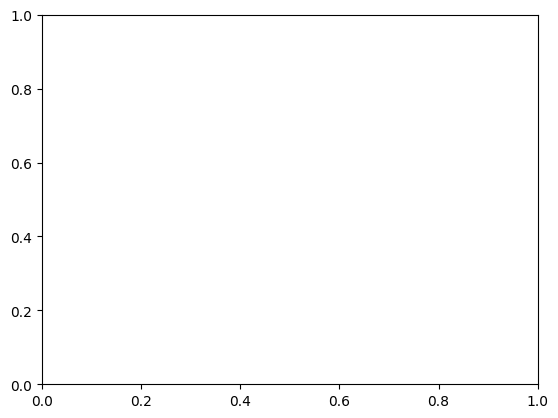

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(close.index, activity.equity_curve(), label="Equity Curve")
ax.plot(close.index, close * engine.portfolio.position("NVDA").qty, label="Close")
ax.legend()
fig.tight_layout()

We can also dump the portfolio activity to a dataframe to look at the results.
Since the opening of the next bar was slightly higher, we had to go into a
negative cash position to get the quantity requested.


In [10]:
df = activity.df()
df.head()

,timestamp,cash,symbols,quantities,prices,asset_values,asset_value,value
0,2018-01-02 00:00:00-05:00,1000.000000,[],[],[],[],0.000000,1000.000000
1,2018-01-03 00:00:00-05:00,-23.827392,[NVDA],[202.88884258031135],[5.253190994262695],[1065.8138406792732],1065.813841,1041.986449
2,2018-01-04 00:00:00-05:00,-23.827392,[NVDA],[202.88884258031135],[5.280882835388184],[1071.4322062741414],1071.432206,1047.604815
3,2018-01-05 00:00:00-05:00,-23.827392,[NVDA],[202.88884258031135],[5.325634002685547],[1080.5117188112213],1080.511719,1056.684327
4,2018-01-08 00:00:00-05:00,-23.827392,[NVDA],[202.88884258031135],[5.488814830780029],[1113.6192881546076],1113.619288,1089.791896
